## Accessing Cloud Optimized Data

The following is an example that uses Shuttle Radar Topography Mission (SRTM) Cloud Optimized GeoTIFF data from the MAAP data store, via MAAP CMR API search. In this example, we read in elevation data using a bounding box tile.

First we install any necessary packages. Please note that the following block of code only needs to be run if needed within a new workspace and that you may need to restart the kernel to use updated packages.

In [1]:
# only run this block if needed in a new workspace
%conda install -y -c conda-forge geopandas shapely folium rasterio pygeos rio-cogeo

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - folium
    - geopandas
    - pygeos
    - rasterio
    - rio-cogeo
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py37h89c1867_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  conda                               4.10.0-py37h89c1867_1 --> 4.10.1-py37h89c1867_0



conda-4.10.1         | 3.1 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


Let's import the `maap` and `pprint` packages and invoke the MAAP.

In [2]:
# import the maap package to handle queries
from maap.maap import MAAP
# import printing package to help display outputs
from pprint import pprint
# invoke the MAAP
maap = MAAP()

We can use the `maap.searchCollection` function to search for the desired collection, in this case the SRTMGL1_COD collection and set the results of the function to a variable. More information about searching for collections may be found [here](https://docs.maap-project.org/en/latest/search/collections.html).

In [3]:
# search for SRTMGL1_COD collection
collection_info = maap.searchCollection(short_name="SRTMGL1_COD", limit=1000)

Perhaps we are only interested in granules (files) from the collection which are within a certain area. We create a string with bounding box values and use the `maap.searchGranule` function with the bounding box values. More information about searching for granules may be found [here](https://docs.maap-project.org/en/latest/search/granules.html).

In [4]:
# set bounding box
bbox = '-101.5,45.5,-100.5,46.5'
# retreive granules from the collection that are within the bounding box
granule_results = maap.searchGranule(short_name="SRTMGL1_COD", bounding_box=bbox , limit=20)

Let's check how many granules we are working with.

In [5]:
# show number of granules in results
len(granule_results)

4

### Inspecting the Results
Now we can work on inspecting our results. In order to do this, we import the `geopandas`,`shapely`, and `folium` packages.

In [6]:
# import geopandas to work with geospatial data
import geopandas as gpd
# import shapely for manipulation and analysis of geometric objects
import shapely as shp
# import folium to visualize data in an interactive leaflet map
import folium

With the above packages imported, we create a function to make polygons from granule items passed to it.

In [7]:
def make_polygons(item):
    """
    Returns shapely.geometry.polygon.Polygon
    Parameters:
    -----------
    item : dictionary
        A result from granule search results returned by maap.searchGranules()
    """
    # get boundary information from granule result
    bounds = item['Granule']['Spatial']['HorizontalSpatialDomain']['Geometry']['BoundingRectangle']
    # get boundary values from `bounds` and convert to floating point number
    item_bbox = [float(value) for value in bounds.values()]
    # use boundary values to create a shapely polygon for the function to return
    bbox_polygon = shp.geometry.box(
        item_bbox[0], 
        item_bbox[1],
        item_bbox[2], 
        item_bbox[3]
    )
    return bbox_polygon

With our `make_polygons` function, we can use the `gpd.GeoSeries` function to create a GeoSeries of all the polygons created from our granule results. According to the [GeoPandas documentation](https://geopandas.org/docs/reference/geoseries.html), a GeoSeries is a "Series [a type of one-dimensional array] object designed to store shapely geometry objects". We use 'EPSG:4326' (WGS 84) for the coordinate reference system. Then we can check the GeoSeries.

In [8]:
# create GeoSeries of all polygons from granule results with WGS 84 coordinate reference system
geometries = gpd.GeoSeries([make_polygons(item) for item in granule_results], crs='EPSG:4326')
# check GeoSeries
geometries

0    POLYGON ((-100.99972 46.00028, -100.99972 44.9...
1    POLYGON ((-100.99972 47.00028, -100.99972 45.9...
2    POLYGON ((-99.99972 46.00028, -99.99972 44.999...
3    POLYGON ((-99.99972 47.00028, -99.99972 45.999...
dtype: geometry

Now we create a list from our bounding box values. Then we use the `centroid` function to get the centroid of our bounding box and set to a point. Next we use `folium.Map` to create a map. For the map's parameters, let's set the centroid point coordinates as the location, "cartodbpositron" for the map tileset, and 7 as the starting zoom level. With our map created, we can create a dictionary containing sytle information for our bounding box. Then we can use `folium.GeoJson` to create GeoJsons from our `geometries` GeoSeries and add them to the map. We also use the `folium.GeoJson` function to create a GeoJson of a polygon created from our bounding box list, name it, and add our style information. Finally, we check the map by displaying it.

In [9]:
# create list of bounding box values
bbox_list =  [float(value) for value in bbox.split(',')]
# get centroid point from bounding box values
center = shp.geometry.box(*bbox_list).centroid
# create map with folium with arguments for lat/lon of map, map tileset, and starting zoom level
m = folium.Map(
    location=[center.y,center.x],
    tiles="cartodbpositron",
    zoom_start=7,
)
# create style information for bounding box
bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}
# create GeoJson of `geometries` and add to map
folium.GeoJson(geometries, name="tiles").add_to(m)
# create GeoJson of `bbox_list` polygon and add to map with specified style
folium.GeoJson(shp.geometry.box(*bbox_list), 
               name="bbox",#).add_to(m)
               style_function=lambda x:bbox_style).add_to(m)
# display map
m

### Creating a Mosaic
Let's check the raster information contained in our granule results. In order to do this, we import some more packages. To read and write files in raster format, import `rasterio`. From `rasterio` we import `merge` to copy valid pixels from an input into an output file, `AWSSession` to set up an Amazon Web Services (AWS) session, and `show` to display images and label axes. Also import `boto3` in order to work with AWS. From `matplotlib`, we want to import `imshow` which allows us to display images from data. Import `numpy` to work with multi-dimensional arrays and `numpy.ma` to work with masked arrays. From `pyproj`, import `Proj` for converting between geographic and projected coordinate reference systems and `Transformer` to make transformations.

In [10]:
# import rasterio for reading and writing in raster format
import rasterio as rio
# copy valid pixels from input files to an output file.
from rasterio.merge import merge
# set up AWS session
from rasterio.session import AWSSession 
# display images, label axes
from rasterio.plot import show
# import boto3 to work with Amazon Web Services
import boto3
# display images from data
from matplotlib.pyplot import imshow
# import numpy to work with multi-dimensional arrays
import numpy as np
# import numpy.ma to work with masked arrays
import numpy.ma as ma
# convert between geographic and projected coordinates and make transformations
from pyproj import Proj, Transformer

Now that we have the necessary packages, let's get a list of Amazon Simple Storage Service (s3) urls to the granules. To start, set up an AWS session. The s3 urls are contained within the `granule_results` list, so we loop through the granules in our results to get the s3 urls and add them to a new list. We can then use the `sort` function to sort the s3 urls in an acending order. Then we can check our s3 url list.

In [11]:
# set up AWS session
aws_session = AWSSession(boto3.Session())
# get the s3 urls to the granules
file_s3 = [item['Granule']['OnlineAccessURLs']['OnlineAccessURL']['URL'] for item in granule_results] 
# sort list in ascending order
file_s3.sort()
# check list
file_s3

['s3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W101.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W102.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W101.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W102.SRTMGL1.tif']

Looks good. We can now check to see that we can read the AWS files and display a thumbnail. Pass the boto3 session to `rio.Env`, which is the GDAL/AWS environment for `rasterio`. Use the `rio.open` function to read in one of the Cloud Optimized GeoTIFFs. Now let's use the `overviews` command to get a list of overviews. Overviews are versions of the data with lower resolution, and can thus increase performance in applications. Let's get the second overview from our list for retrieving a thumbnail. Retrieve a thumbnail by reading the first band of our file and setting the shape of the new output array. The shape can be set with a tuple of integers containing the number of datasets as well as the file `height` and `width` of the file divided by our integer from the overview list. Now use the `show` function to display the thumbnail.

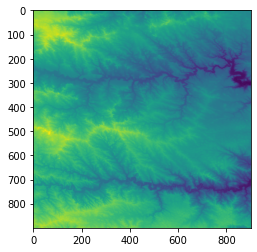

<AxesSubplot:>

In [12]:
# prove that we can read the AWS files
# for more information - https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
with rio.Env(aws_session):
    with rio.open(file_s3[1], 'r') as src:
        # list of overviews
        oviews = src.overviews(1)
        # get second item from list to retrieve a thumbnail
        oview = oviews[1]
        # read first band of file and set shape of new output array
        thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
# now display the thumbnail
show(thumbnail)

Since we verified that we can read the AWS files and display a thumbnail, we can create a mosaic from all of the rasters in our `file_s3` list. To do this, again pass the boto3 session to `rio.Env`. Then create a list which contains all of the read in Cloud Optimized GeoTIFFs (this may take a while).

In [15]:
# create a mosaic from all the images
with rio.Env(aws_session):
    sources = [rio.open(raster) for raster in file_s3]

Now we can use the `merge` function to merge these source files together using our list of bounding box values as the bounds. `merge` copies the valid pixels from input rasters and outputs them to a new raster.

In [16]:
# merge the source files
mosaic, out_trans = merge(sources, bounds = bbox_list)

ValueError: operands could not be broadcast together with shapes (1,1800,1800) (1,1801,1800) 

Lastly, we use `ma.masked_values` for masking all of the NoData values, allowing the mosaic to be plotted correctly. `ma.masked_values` returns a MaskedArray in which a data array is masked by an approximate value. For the parameters, let's use our mosaic as the data array and the integer of the "nodata" value as the value to mask by. Now we can use `show` to display our masked raster using `matplotlib` with a "terrain" colormap.

In [ ]:
# mask the NoData values so it can be plotted correctly
masked_mosaic = ma.masked_values(mosaic, int(sources[0].nodatavals[0]))
# display the masked mosaic
show(masked_mosaic, cmap = 'terrain')